In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [87]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5000 files belonging to 3 classes.
Using 4000 files for training.
Found 5000 files belonging to 3 classes.
Using 1000 files for validation.


In [60]:
# number and names of Classes
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(3, ['AD', 'CN', 'MCI'])

2023-05-16 13:33:18.603256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4000]
	 [[{{node Placeholder/_4}}]]
2023-05-16 13:33:18.614976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4000]
	 [[{{node Placeholder/_0}}]]


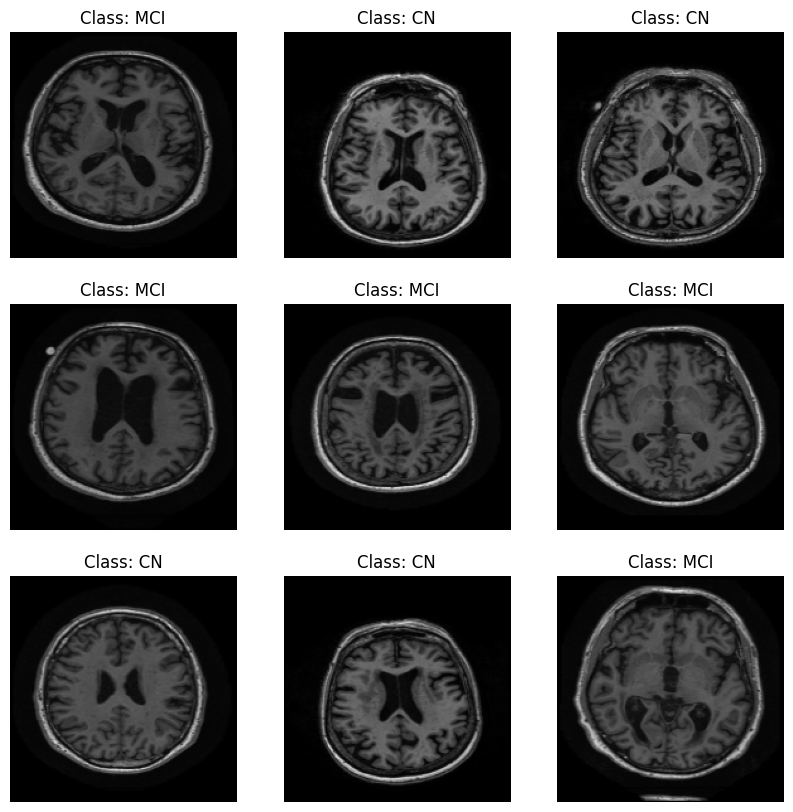

In [61]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Class: " + train_ds.class_names[labels[i]])
    plt.axis("off")

In [62]:
# Number of images in each class
NUM_IMAGES = []

for label in classnames:
    dir_name = "Dataset" +'/'+ label
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

NUM_IMAGES,classnames

([1124, 1440, 2437], ['AD', 'CN', 'MCI'])

In [63]:
train_ds.class_names = classnames
val_ds.class_names = classnames

NUM_CLASSES = len(classnames)
NUM_CLASSES

3

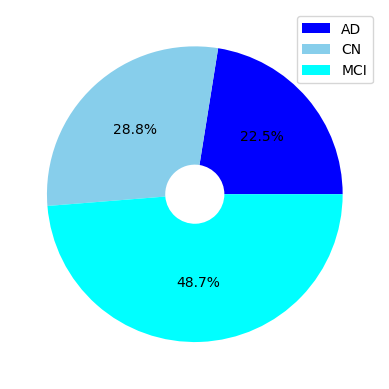

In [64]:
# Before Oversampling
# Visualization of each class with pie chart
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(NUM_IMAGES, autopct='%1.1f%%', wedgeprops=dict(width=0.8), colors=['blue','skyblue', 'aqua'])
plt.legend(labels=train_ds.class_names)

In [65]:
# Performing Image Augmentation to have more data samples
IMG_SIZE = 180
IMAGE_SIZE = [180, 180]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="Dataset"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=8000, shuffle=False)

Found 5000 images belonging to 3 classes.


In [66]:
train_data, train_labels = train_data_gen.next()

# Oversampling technique

In [67]:
# Shape of data before oversampling
print(train_data.shape, train_labels.shape)

(5000, 180, 180, 3) (5000, 3)


In [68]:
# Performing over-sampling of the data, since the classes are imbalanced
# After oversampling using SMOTE
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(7308, 180, 180, 3) (7308, 3)


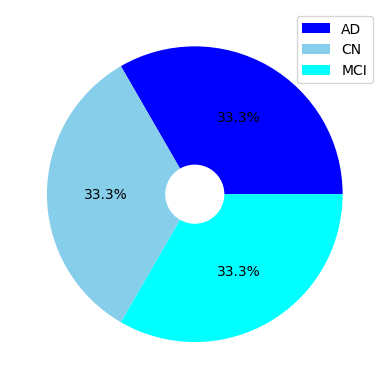

In [69]:
# Show pie plot for dataset (after oversampling)
# Visualization of each class with pie chart
images_after = [2436,2436,2436]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(images_after, autopct='%1.1f%%',wedgeprops=dict(width=0.8), colors=['blue','skyblue', 'aqua'])
plt.legend(labels=train_ds.class_names)

# Spliting data

In [70]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Building the model

In [71]:
#-------VGG16--------

vgg = VGG16(input_shape=(180,180,3),weights='imagenet',include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input,outputs=prediction)

In [73]:
!pip install pydot

# Plotting layers as an image
plot_model(modelvgg,to_file="alzahimer.png",show_shapes=True)

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
You should consider upgrading via the '/Users/vladaefremenko/Desktop/Лабораторные/Proj/bin/python -m pip install --upgrade pip' command.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [79]:
# Optimizing model
modelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights_VGG.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

modelvgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0   

# Training model using my data

In [80]:
# Fitting the model
hist = modelvgg.fit(
           train_data, train_labels,
           epochs=15,validation_data=(val_data, val_labels),
            callbacks=[checkpoint, lr_reduce])

Epoch 1/15
147/147 [==============================] - 547s 4s/step - loss: 0.4429 - accuracy: 0.8385 - val_loss: 0.5657 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 2/15
147/147 [==============================] - 585s 4s/step - loss: 0.3502 - accuracy: 0.8894 - val_loss: 0.3788 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 3/15
147/147 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.9136
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
147/147 [==============================] - 569s 4s/step - loss: 0.2977 - accuracy: 0.9136 - val_loss: 0.3354 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 4/15
147/147 [==============================] - 592s 4s/step - loss: 0.2374 - accuracy: 0.9495 - val_loss: 0.3262 - val_accuracy: 0.9085 - lr: 3.0000e-04
Epoch 5/15
147/147 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9521
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
147/147 [==============================

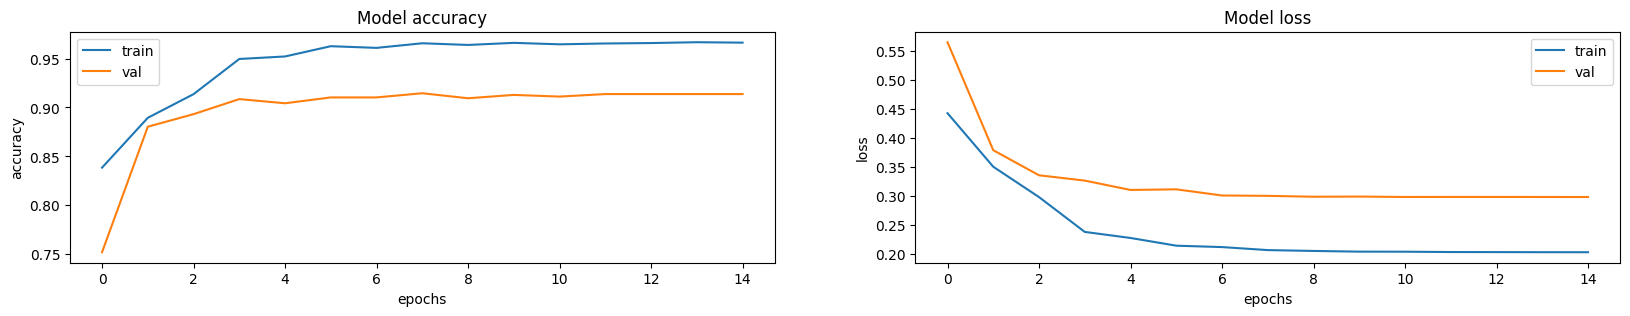

In [81]:
# Plotting accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [82]:
# Evaluation using test data
test_scores = modelvgg.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

46/46 [==============================] - 144s 3s/step - loss: 0.2885 - accuracy: 0.9111
Testing Accuracy: 91.11%


In [83]:
pred_labels = modelvgg.predict(test_data)

46/46 [==============================] - 132s 3s/step


# Confusion matrix

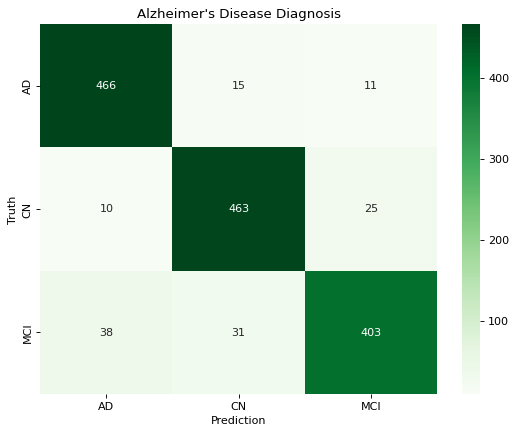

In [84]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

# Classification report

In [85]:
print(classification_report(test_ls, pred_ls, target_names=classnames))

              precision    recall  f1-score   support

          AD       0.91      0.95      0.93       492
          CN       0.91      0.93      0.92       498
         MCI       0.92      0.85      0.88       472

    accuracy                           0.91      1462
   macro avg       0.91      0.91      0.91      1462
weighted avg       0.91      0.91      0.91      1462

